# Import libraries and data

In [1]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns

from matplotlib_venn import venn2, venn3
from scipy.stats import mannwhitneyu
from sklearn.metrics import balanced_accuracy_score
from utils import get_uniprot, increase_stringency_CSF, print_p_val

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
data_path = os.getcwd() + "/Datasets/"
fig_path = os.getcwd() + "/Figures/"

## Brain proteome (HPA)

In [3]:
brain_elevated = pd.read_csv(data_path + "Brain/Brain_elevated.csv")

## Feature data sets

### Unfiltered

In [4]:
# all human proteins
df_all = pd.read_csv(data_path + "/Features/df_features.csv")

### MS filtered

In [5]:
# # all human proteins
df = pd.read_csv(data_path + "/Features/df_features_MS_filtered.csv")
# all proteins detected in brain
df_detected = pd.read_csv(data_path + "/Features/df_features_brain_detected_MS_filtered.csv")
# all proteins detected in brain that were not part of the training and testing (i.e. brain elevated) set
df_val = pd.read_csv(data_path + "/Features/df_features_brain_detected_val_MS_filtered.csv")
# all proteins elevated in brain
df_elevated = pd.read_csv(data_path + "/Features/df_features_brain_elevated_MS_filtered.csv")

In [6]:
# drop non-sequence-based features
df_all.drop(["RNA_binding", "DNA_binding", "Ectodomain_shedding", "EV"], axis=1, inplace=True)
df.drop(["RNA_binding", "DNA_binding", "Ectodomain_shedding", "EV"], axis=1, inplace=True)

## CSF

In [7]:
csf = pd.read_csv(data_path + "CSF/csf.csv")

## Model and scaler

In [8]:
with open(os.getcwd() + "/Models/LogisticClassifier_L2_1plus.pkl", "rb") as f:  
    L2_CSF1 = pickle.load(f)
with open(os.getcwd() + "/Models/LogisticClassifier_L2_2plus.pkl", "rb") as f:  
    L2_CSF2 = pickle.load(f)
with open(os.getcwd() + "/Models/LogisticClassifier_L2_3plus.pkl", "rb") as f:  
    L2_CSF3 = pickle.load(f)

In [9]:
with open(os.getcwd() + "/Models/Standard_scaler.pkl", "rb") as f:  
    scaler = pickle.load(f)

# Prediction on novel proteins

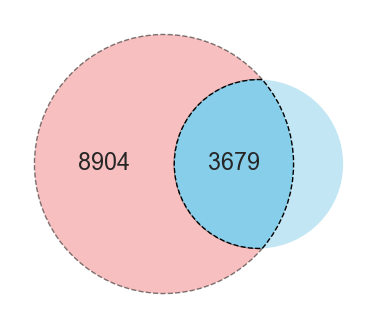

In [10]:
brain_detected_val_set = set(df_val["Uniprot"])
csf_set = set(csf["Uniprot"])

sns.set(style=("ticks"), font_scale=1.4)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
colors=("lightcoral", "skyblue")
alpha = 0.5

# entire dataset
v = venn2([brain_detected_val_set, csf_set], ["", ""], 
    set_colors=colors, alpha=alpha)
v.get_patch_by_id("11").set_color("skyblue")
v.get_patch_by_id("11").set_alpha(1.0)
v.get_patch_by_id("11").set_linestyle("dashed")
v.get_patch_by_id("11").set_edgecolor("black")
v.get_patch_by_id("10").set_linestyle("dashed")
v.get_patch_by_id("10").set_edgecolor("black")
v.get_label_by_id("01").set_text("")
plt.show()

plt.show()
fig.savefig(fig_path + "Venn_diagrams_overlap_brain_detected_CSF.png", bbox_inches="tight", dpi=300, transparent=True)

In [11]:
# define variables and target
X = df_all.drop(["Uniprot", "Sequence", "CSF"], axis=1)
y = df_all["CSF"]

# define continuous variables
cont = ['Length', 'Molecular weight', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 
        'V', 'W', 'Y', 'Isoelectric point', 'Instability index', 'Solubility', 'Disorder_NSP', 'Helix_NSP', 'Coil_NSP', 
        'Sheet_NSP', 'ExpAA', 'First60ExpAA', 'PredHel']

# preprocess data with same scaler as training data
X_scal = X.copy()
X_scal[cont] = scaler.transform(X_scal[cont])

print("Number of features:", len(X.columns))

Number of features: 55


In [12]:
df_pred = df_all.copy()
models = [L2_CSF1, L2_CSF2, L2_CSF3]
model_names = ["L2_CSF1", "L2_CSF2", "L2_CSF3"]

for i, m in enumerate(models):
    # calculate probabilities with trained model
    proba = m.predict_proba(X_scal)
    # create dataframe of probabilities
    proba_df = pd.DataFrame(proba, columns=["non_CSF", "CSF"])
    # add probabilities to main dataframe
    df_pred[model_names[i]] = proba_df["CSF"]

# order dataframe by probabilities and reset index
df_pred.sort_values(by="L2_CSF1", ascending=False, inplace=True)
df_pred.reset_index(drop=True, inplace=True)

## Create data subsets

In [13]:
df_elevated_pred = df_pred[df_pred["Uniprot"].isin(df_elevated["Uniprot"])]
print("Number of proteins in brain elevated set:", len(df_elevated_pred))

df_detected_pred = df_pred[df_pred["Uniprot"].isin(df_detected["Uniprot"])]
print("Number of proteins in brain detected set:", len(df_detected_pred))

df_val_pred = df_pred[df_pred["Uniprot"].isin(df_val["Uniprot"])]
print("Number of proteins in brain detected validation set:", len(df_val_pred))

Number of proteins in brain elevated set: 2079
Number of proteins in brain detected set: 14662
Number of proteins in brain detected validation set: 12583


In [14]:
# create datasets without ambiguous proteins
print("Brain elevated set")
print("CSF2+")
df_elevated_pred_CSF2 = increase_stringency_CSF(df_elevated_pred, csf, 2)
print("CSF3+")
df_elevated_pred_CSF3 = increase_stringency_CSF(df_elevated_pred, csf, 3)

print("--------------")
print("Brain detected validation set")
print("CSF2+")
df_val_pred_CSF2 = increase_stringency_CSF(df_val_pred, csf, 2)
print("CSF3+")
df_val_pred_CSF3 = increase_stringency_CSF(df_val_pred, csf, 3)

Brain elevated set
CSF2+
Number of CSF proteins to be removed: 243
Number of CSF proteins left: 649
CSF3+
Number of CSF proteins to be removed: 367
Number of CSF proteins left: 525
--------------
Brain detected validation set
CSF2+
Number of CSF proteins to be removed: 1368
Number of CSF proteins left: 2311
CSF3+
Number of CSF proteins to be removed: 1934
Number of CSF proteins left: 1745


In [15]:
# create subsets of datasets based on CSF class annotation
print("Brain elevated set")
df_elevated_pred_CSF1_CSF = df_elevated_pred[df_elevated_pred["CSF"] == 1]
df_elevated_pred_CSF1_non_CSF = df_elevated_pred[df_elevated_pred["CSF"] == -1]
print("Number of CSF proteins in brain detected validation set:", len(df_elevated_pred_CSF1_CSF))
print("Number of non-CSF proteins in brain detected validation set:", len(df_elevated_pred_CSF1_non_CSF))
df_elevated_pred_CSF2_CSF = df_elevated_pred_CSF2[df_elevated_pred_CSF2["CSF"] == 1]
df_elevated_pred_CSF2_non_CSF = df_elevated_pred_CSF2[df_elevated_pred_CSF2["CSF"] == -1]
print("Number of CSF proteins in brain detected validation set:", len(df_elevated_pred_CSF2_CSF))
print("Number of non-CSF proteins in brain detected validation set:", len(df_elevated_pred_CSF2_non_CSF))
df_elevated_pred_CSF3_CSF = df_elevated_pred_CSF3[df_elevated_pred_CSF3["CSF"] == 1]
df_elevated_pred_CSF3_non_CSF = df_elevated_pred_CSF3[df_elevated_pred_CSF3["CSF"] == -1]
print("Number of CSF proteins in brain detected validation set:", len(df_elevated_pred_CSF3_CSF))
print("Number of non-CSF proteins in brain detected validation set:", len(df_elevated_pred_CSF3_non_CSF))

print("--------------")
print("Brain detected validation set")
df_val_pred_CSF1_CSF = df_val_pred[df_val_pred["CSF"] == 1]
df_val_pred_CSF1_non_CSF = df_val_pred[df_val_pred["CSF"] == -1]
print("Number of CSF proteins in brain detected validation set (CSF1+):", len(df_val_pred_CSF1_CSF))
print("Number of non-CSF proteins in brain detected validation set (CSF1+):", len(df_val_pred_CSF1_non_CSF))
df_val_pred_CSF2_CSF = df_val_pred_CSF2[df_val_pred_CSF2["CSF"] == 1]
df_val_pred_CSF2_non_CSF = df_val_pred_CSF2[df_val_pred_CSF2["CSF"] == -1]
print("Number of CSF proteins in brain detected validation set (CSF2+):", len(df_val_pred_CSF2_CSF))
print("Number of non-CSF proteins in brain detected validation set (CSF2+):", len(df_val_pred_CSF2_non_CSF))
df_val_pred_CSF3_CSF = df_val_pred_CSF3[df_val_pred_CSF3["CSF"] == 1]
df_val_pred_CSF3_non_CSF = df_val_pred_CSF3[df_val_pred_CSF3["CSF"] == -1]
print("Number of CSF proteins in brain detected validation set (CSF3+):", len(df_val_pred_CSF3_CSF))
print("Number of non-CSF proteins in brain detected validation set (CSF3+):", len(df_val_pred_CSF3_non_CSF))

Brain elevated set
Number of CSF proteins in brain detected validation set: 892
Number of non-CSF proteins in brain detected validation set: 1187
Number of CSF proteins in brain detected validation set: 649
Number of non-CSF proteins in brain detected validation set: 1187
Number of CSF proteins in brain detected validation set: 525
Number of non-CSF proteins in brain detected validation set: 1187
--------------
Brain detected validation set
Number of CSF proteins in brain detected validation set (CSF1+): 3679
Number of non-CSF proteins in brain detected validation set (CSF1+): 8904
Number of CSF proteins in brain detected validation set (CSF2+): 2311
Number of non-CSF proteins in brain detected validation set (CSF2+): 8904
Number of CSF proteins in brain detected validation set (CSF3+): 1745
Number of non-CSF proteins in brain detected validation set (CSF3+): 8904


# Prediction results

## Brain elevated HPA proteome

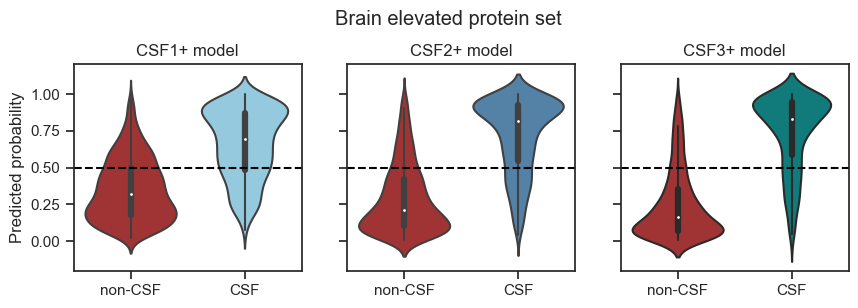

In [16]:
# brain elevated 
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 3, figsize=(10,3), sharey=True)
fig.suptitle("Brain elevated protein set")
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.8)

sns.violinplot(x="CSF", y="L2_CSF1", data=df_elevated_pred, palette=["firebrick", "skyblue"], ax=ax[0])
ax[0].set(xlabel=None, ylabel="Predicted probability", title="CSF1+ model")
sns.violinplot(x="CSF", y="L2_CSF2", data=df_elevated_pred_CSF2, palette=["firebrick", "steelblue"], ax=ax[1])
ax[1].set(xlabel=None, ylabel=None, title="CSF2+ model")
sns.violinplot(x="CSF", y="L2_CSF3", data=df_elevated_pred_CSF3, palette=["firebrick", "darkcyan"], ax=ax[2])
ax[2].set(xlabel=None, ylabel=None, title="CSF3+ model")

for i in range(3):
    ax[i].set_xticklabels(["non-CSF", "CSF"])
    ax[i].axhline(0.5, color="black", linestyle="--")

plt.show()
fig.savefig(fig_path + "Probability_scores_brain_elevated_L2.png", bbox_inches="tight", dpi=300, transparent=True)

In [17]:
sens_CSF1 = len(df_elevated_pred_CSF1_CSF[df_elevated_pred_CSF1_CSF["L2_CSF1"] > 0.5])/len(df_elevated_pred_CSF1_CSF)
print("Correctly predicted CSF proteins (CSF1+): %.4f" % sens_CSF1)
sens_CSF2 = len(df_elevated_pred_CSF2_CSF[df_elevated_pred_CSF2_CSF["L2_CSF2"] > 0.5])/len(df_elevated_pred_CSF2_CSF)
print("Correctly predicted CSF proteins (CSF2+): %.4f" % sens_CSF2)
sens_CSF3 = len(df_elevated_pred_CSF3_CSF[df_elevated_pred_CSF3_CSF["L2_CSF3"] > 0.5])/len(df_elevated_pred_CSF3_CSF)
print("Correctly predicted CSF proteins (CSF3+): %.4f" % sens_CSF3)

Correctly predicted CSF proteins (CSF1+): 0.7298
Correctly predicted CSF proteins (CSF2+): 0.7735
Correctly predicted CSF proteins (CSF3+): 0.8019


In [18]:
spec_CSF1 = len(df_elevated_pred_CSF1_non_CSF[df_elevated_pred_CSF1_non_CSF["L2_CSF1"] < 0.5])/len(df_elevated_pred_CSF1_non_CSF)
print("Correctly predicted non-CSF proteins (CSF1+): %.4f" % spec_CSF1)
spec_CSF2 = len(df_elevated_pred_CSF2_non_CSF[df_elevated_pred_CSF2_non_CSF["L2_CSF2"] < 0.5])/len(df_elevated_pred_CSF2_non_CSF)
print("Correctly predicted non-CSF proteins (CSF2+): %.4f" % spec_CSF2)
spec_CSF3 = len(df_elevated_pred_CSF3_non_CSF[df_elevated_pred_CSF3_non_CSF["L2_CSF3"] < 0.5])/len(df_elevated_pred_CSF3_non_CSF)
print("Correctly predicted non-CSF proteins (CSF3+): %.4f" % spec_CSF3)

Correctly predicted non-CSF proteins (CSF1+): 0.7548
Correctly predicted non-CSF proteins (CSF2+): 0.8189
Correctly predicted non-CSF proteins (CSF3+): 0.8467


## Brain detected validation HPA proteome

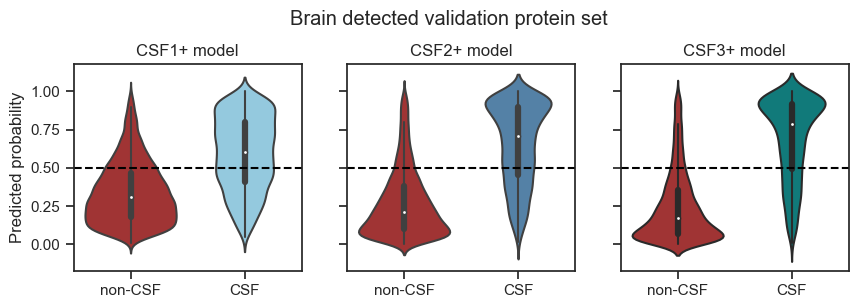

In [19]:
# brain detected validation
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 3, figsize=(10,3), sharey=True)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.8)
fig.suptitle("Brain detected validation protein set")

sns.violinplot(x="CSF", y="L2_CSF1", data=df_val_pred, palette=["firebrick", "skyblue"], ax=ax[0])
ax[0].set(xlabel=None, ylabel="Predicted probability", title="CSF1+ model")
sns.violinplot(x="CSF", y="L2_CSF2", data=df_val_pred_CSF2, palette=["firebrick", "steelblue"], ax=ax[1])
ax[1].set(xlabel=None, ylabel=None, title="CSF2+ model")
sns.violinplot(x="CSF", y="L2_CSF3", data=df_val_pred_CSF3, palette=["firebrick", "darkcyan"], ax=ax[2])
ax[2].set(xlabel=None, ylabel=None, title="CSF3+ model")

for i in range(3):
    ax[i].set_xticklabels(["non-CSF", "CSF"])
    ax[i].axhline(0.5, color="black", linestyle="--")

plt.show()
fig.savefig(fig_path + "Probability_scores_brain_detected_val_L2.png", bbox_inches="tight", dpi=300, transparent=True)

In [20]:
sens_CSF1 = len(df_val_pred_CSF1_CSF[df_val_pred_CSF1_CSF["L2_CSF1"] > 0.5])/len(df_val_pred_CSF1_CSF)
print("Correctly predicted CSF proteins (CSF1+): %.4f" % sens_CSF1)
sens_CSF2 = len(df_val_pred_CSF2_CSF[df_val_pred_CSF2_CSF["L2_CSF2"] > 0.5])/len(df_val_pred_CSF2_CSF)
print("Correctly predicted CSF proteins (CSF2+): %.4f" % sens_CSF2)
sens_CSF3 = len(df_val_pred_CSF3_CSF[df_val_pred_CSF3_CSF["L2_CSF3"] > 0.5])/len(df_val_pred_CSF3_CSF)
print("Correctly predicted CSF proteins (CSF3+): %.4f" % sens_CSF3)

Correctly predicted CSF proteins (CSF1+): 0.6320
Correctly predicted CSF proteins (CSF2+): 0.7049
Correctly predicted CSF proteins (CSF3+): 0.7484


In [21]:
spec_CSF1 = len(df_val_pred_CSF1_non_CSF[df_val_pred_CSF1_non_CSF["L2_CSF1"] < 0.5])/len(df_val_pred_CSF1_non_CSF)
print("Correctly predicted non-CSF proteins (CSF1+): %.4f" % spec_CSF1)
spec_CSF2 = len(df_val_pred_CSF2_non_CSF[df_val_pred_CSF2_non_CSF["L2_CSF2"] < 0.5])/len(df_val_pred_CSF2_non_CSF)
print("Correctly predicted non-CSF proteins (CSF2+): %.4f" % spec_CSF2)
spec_CSF3 = len(df_val_pred_CSF3_non_CSF[df_val_pred_CSF3_non_CSF["L2_CSF3"] < 0.5])/len(df_val_pred_CSF3_non_CSF)
print("Correctly predicted non-CSF proteins (CSF3+): %.4f" % spec_CSF3)

Correctly predicted non-CSF proteins (CSF1+): 0.7896
Correctly predicted non-CSF proteins (CSF2+): 0.8504
Correctly predicted non-CSF proteins (CSF3+): 0.8582


In [22]:
y_true = df_val_pred["CSF"]
y_pred = np.where(df_val_pred["L2_CSF1"] > 0.5, 1, -1)
y_true_CSF2 = df_val_pred_CSF2["CSF"]
y_pred_CSF2 = np.where(df_val_pred_CSF2["L2_CSF2"] > 0.5, 1, -1)
y_true_CSF3 = df_val_pred_CSF3["CSF"]
y_pred_CSF3 = np.where(df_val_pred_CSF3["L2_CSF3"] > 0.5, 1, -1)

print("Balanced accuracy (CSF1+): %.4f" % balanced_accuracy_score(y_true, y_pred))
print("Balanced accuracy (CSF2+): %.4f" % balanced_accuracy_score(y_true_CSF2, y_pred_CSF2))
print("Balanced accuracy (CSF3+): %.4f" % balanced_accuracy_score(y_true_CSF3, y_pred_CSF3))

Balanced accuracy (CSF1+): 0.7108
Balanced accuracy (CSF2+): 0.7776
Balanced accuracy (CSF3+): 0.8033


## Prediction confidence across CSF study number

In [23]:
# merge CSF studies with probability scores
proba_val_across_study_number = df_val_pred[["Uniprot", "L2_CSF1", "L2_CSF2", "L2_CSF3"]].merge(csf[["Uniprot", "#Studies"]], 
    on="Uniprot", how="left")
proba_val_across_study_number["#Studies"].fillna(0, inplace=True)
proba_val_across_study_number["#Studies"] = proba_val_across_study_number["#Studies"].astype(int)

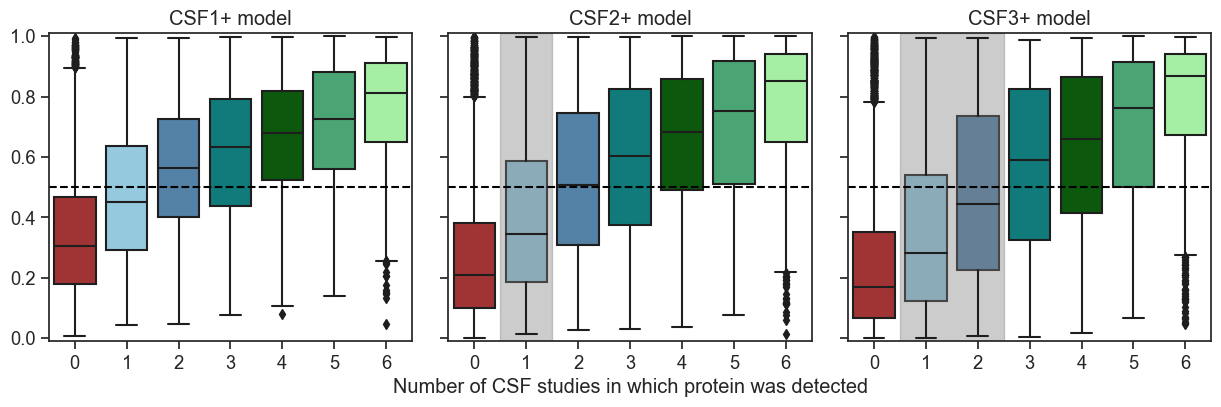

In [24]:
sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 3, figsize=(15,4), sharey=True)
fig.subplots_adjust(wspace=0.1)
plt.setp(ax, ylim=(-0.01, 1.01))

palette=["firebrick", "skyblue", "steelblue", "darkcyan", "darkgreen", "mediumseagreen", "palegreen", "yellowgreen"]

sns.boxplot(x="#Studies", y="L2_CSF1", data=proba_val_across_study_number, palette=palette, ax=ax[0])
ax[0].set(xlabel=None, ylabel=None, title="CSF1+ model")

sns.boxplot(x="#Studies", y="L2_CSF2", data=proba_val_across_study_number, palette=palette, ax=ax[1])
ax[1].set(xlabel="Number of CSF studies in which protein was detected", ylabel=None, title="CSF2+ model")
ax[1].axvspan(0.5, 1.5, color="grey", alpha=0.4)

sns.boxplot(x="#Studies", y="L2_CSF3", data=proba_val_across_study_number, palette=palette, ax=ax[2])
ax[2].set(xlabel=None, ylabel=None, title="CSF3+ model")
ax[2].axvspan(0.5, 2.5, color="grey", alpha=0.4)

for i in range(3):
    ax[i].axhline(0.5, color="black", linestyle="--")
    
plt.show()
fig.savefig(fig_path + "Probability_scores_vs_study_number.png", bbox_inches="tight", dpi=300, transparent=True)

# Save prediction dataframe

In [25]:
df_full_results = df_pred[["Uniprot", "L2_CSF1", "L2_CSF2", "L2_CSF3"]]

In [26]:
# merge CSF studies with probability scores
df_full_results = df_full_results.merge(csf[["Uniprot", "#Studies"]], on="Uniprot", how="left")
df_full_results["#Studies"].fillna(0, inplace=True)
df_full_results["#Studies"] = df_full_results["#Studies"].astype(int)

In [27]:
df_full_results["Detected in the brain"] = np.where(df_full_results["Uniprot"].isin(df_detected["Uniprot"]), "Yes", "No")
df_full_results["Part of the training data"] = np.where(df_full_results["Uniprot"].isin(df_elevated["Uniprot"]), "Yes", "No")

In [28]:
df_full_results.columns = ["Uniprot", "Probability score (CSF1+ classification model)", 
    "Probability score (CSF2+ classification model)", "Probability score (CSF3+ classification model)",
    "Number of CSF studies", "Part of the brain detected HPA proteome", "Part of the training data"]

In [29]:
df_full_results[:5]

,Uniprot,Probability score (CSF1+ classification model),Probability score (CSF2+ classification model),Probability score (CSF3+ classification model),Number of CSF studies,Part of the brain detected HPA proteome,Part of the training data
0,Q7Z5P9,0.999955,0.999863,0.998660,1,No,No
1,Q8WXI7,0.999718,0.992367,0.413202,2,No,No
2,Q02817,0.999711,0.998488,0.995803,0,No,No
3,E2RYF6,0.999502,0.996012,0.999614,0,No,No
4,P15502,0.999405,0.999890,0.999907,5,Yes,No


In [30]:
df_full_results.to_excel(data_path + "Biomarker_discovery/Probability_scores_human_proteome.xlsx", index=False)